In [ ]:
"""trains a prophet model on each produce item's data

includes cells that take care of hyperparameter tuning (using a randomized search), testing, and prediction

outputs MAPE"""

In [1]:
# use prophet as my "simple" model
import fbprophet as fp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import RandomizedSearchCV
sns.set_style("darkgrid")
import time
import math
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import random

In [2]:
def read_trimmed_data_prophet(city, veggie, data_dir):
    # reads in cleaned .csv data for one city and veggie, returns in the format for prophet
    output_data = pd.read_csv(data_dir+veggie+'_'+city+'_TRIM.csv')
    output_data.rename(columns={'Date': 'ds', 'IA Average Price': 'y'}, inplace=True)
    output_data['ds'] = pd.to_datetime(output_data['ds'])
    output_data = output_data[['ds', 'y']].dropna()
    output_data = output_data.reset_index(drop=True)
    return output_data

In [3]:
def read_trimmed_data_notprophet(city, veggie, data_dir):
    # reads in cleaned .csv data for one city and veggie, returns the data as it was read in
    output_data = pd.read_csv(data_dir+veggie+'_'+city+'_TRIM.csv')
    output_data.rename(columns={'Date': 'Date'}, inplace=True)
    output_data['Date'] = pd.to_datetime(output_data['Date'])
    output_data = output_data.sort_values(by='Date')
    output_data = output_data.reset_index(drop=True)
    output_data = output_data.dropna()
    return output_data

In [4]:
def nearest_date(dates, targdate):
    # given a pd series of dates and a target date, returns date from the series closest to target date (and distance)
    for i in dates:
        i = i.to_pydatetime()
    nearest = min(dates, key=lambda x: abs(x - targdate))
    timedelta = abs(nearest - targdate)
    return nearest, timedelta

In [5]:
def plot_pct_misses_prophet(miss_array, city, title):
    # plot barchart of percent misses
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    
    xpos = np.arange(len(miss_array['veggie']))                
    plot = plt.bar(xpos, miss_array['mape'])
    plt.xticks(xpos, miss_array['veggie'])
    plt.ylabel('MAPE', fontsize=14)
    plt.title(title+'_'+city)

    plt.savefig(title+'_'+city+'_pctmiss.png', format='png', bbox_inches='tight')

In [6]:
# veggie and city data
veggienames = ['APPLES','APRICOTS','ASPARAGUS','AVOCADOS','BANANAS','BEANS','BEETS','BLACKBERRIES','BLUEBERRIES','BROCCOLI','CABBAGE','CANTALOUPS','CARROTS','CAULIFLOWER','CELERY','CHERRIES','CLEMENTINES', 'CUCUMBERS','ENDIVE','GARLIC','GINGER+ROOT','GRAPEFRUIT','GRAPES','HONEYDEWS','KIWIFRUIT','LEMONS','LETTUCE%2C+ICEBERG','LETTUCE%2C+ROMAINE','LETTUCE%2C+RED+LEAF','LETTUCE%2C+GREEN+LEAF', 'LIMES','NECTARINES','OKRA','ORANGES','PEACHES','PEARS','PEAS+GREEN','PEPPERS%2C+BELL+TYPE','PINEAPPLES','PLUMS','POTATOES','RADISHES','RASPBERRIES','RHUBARB','SPINACH','SQUASH','STRAWBERRIES']
cities = ['NEW+YORK']

#cities=['LOS+ANGELES']
#veggienames = ['PEARS']
datadir = '../trimmed_data_and_plots/'

# master start date
master_start_date = '20070601'
master_start_date= pd.to_datetime(master_start_date)


In [7]:


# cross_validation

# define start and end dates for cross-validation, window step and horizon
xval_start_date = 8*365
xval_end_date = pd.to_datetime('20170530')
xval_period = 100
xval_horizon = 90

# define parameter grids to search over
chgpt_range = [0.8]
chgpt_pscale = [0.05, 0.3, 0.5]
yrly_season = [8, 10, 15]
season_mode=['additive']
# number of times to resample
n_xval_iters = 5

def random_grid_search(params):
    # take in tuple of params, randomly sample from each element in the tuple
    selected_params = []
    for param in params:
        selected_params.append(random.choice(param))
    return selected_params

best_params = []
time1=time.time()
# do this for all produce items, cities
for c in cities:
    for v in veggienames:
        # for each item cross validate n_xval_iters times
        xval_output_stats = []
        try:
            for i in range(n_xval_iters):
                parameters = random_grid_search((chgpt_range, chgpt_pscale, yrly_season, season_mode))
                # read in data 
                data = read_trimmed_data_prophet(c, v, datadir)
                # nearest dates in the data to end dates,
                nearest_xval_end,_ = nearest_date(data['ds'], xval_end_date)

                # trim the dates beyond the xval set off the dataset
                xval_data = data.where(data['ds']<nearest_xval_end).dropna()

                # initialize prophet model with sampled parameters, fit data
                m = fp.Prophet(weekly_seasonality=False, daily_seasonality=False, 
                              changepoint_range=parameters[0],
                              changepoint_prior_scale=parameters[1],
                              yearly_seasonality=parameters[2],
                              seasonality_mode=parameters[3])

                m.fit(xval_data)

                # cross validate using the xval window
                m_cv = cross_validation(m, initial=str(xval_start_date)+' days', period=str(xval_period)+' days', horizon = str(xval_horizon)+' days')
                # compute performance metrics
                m_p = performance_metrics(m_cv, rolling_window=xval_horizon)
                # store result with params
                parameters.append(m_p['mape'].values[0])

                xval_output_stats.append(parameters)
            # find best parameter combo
            stats = pd.DataFrame(xval_output_stats, columns=['chgpt_range', 'chgpt_pscale', 'yrly_season', 'season_mode','mape'])
            stats = stats.sort_values('mape')
            # put best parameter combo into output list
            best_stats = stats.iloc[0].values.tolist()
            best_stats = [c]+[v]+best_stats
            best_params.append(best_stats)
            print('finished '+c+' '+v)
        except ValueError:
            print('warning, problem setting the xval dates...skipping '+c+' '+v)

print('done in ', time.time()-time1)
output_best_stats = pd.DataFrame(best_params, columns=['city','veggie','chgpt_range', 'chgpt_pscale', 'yrly_season', 'season_mode','mape'])

output_best_stats.to_csv('prophet_crossval_bestparams.csv')


/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES APPLES


INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-07-05 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-07-05 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-07-05 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-07-05 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-07-05 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES APRICOTS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES ASPARAGUS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES AVOCADOS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES BANANAS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES BEANS


INFO:fbprophet.diagnostics:Making 3 forecasts with cutoffs between 2016-08-09 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 3 forecasts with cutoffs between 2016-08-09 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 3 forecasts with cutoffs between 2016-08-09 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 3 forecasts with cutoffs between 2016-08-09 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 3 forecasts with cutoffs between 2016-08-09 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES BEETS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES BLACKBERRIES


INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2016-01-22 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2016-01-22 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2016-01-22 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2016-01-22 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2016-01-22 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES BLUEBERRIES


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES BROCCOLI


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-06-05 00:00:00 and 2017-01-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-06-05 00:00:00 and 2017-01-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-06-05 00:00:00 and 2017-01-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-06-05 00:00:00 and 2017-01-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-06-05 00:00:00 and 2017-01-25 00:00:00


finished LOS+ANGELES CABBAGE


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES CANTALOUPS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES CARROTS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES CAULIFLOWER


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES CELERY


INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2015-10-10 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2015-10-10 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2015-10-10 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2015-10-10 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2015-10-10 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES CHERRIES


INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-09-05 00:00:00 and 2017-01-17 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-09-05 00:00:00 and 2017-01-17 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-09-05 00:00:00 and 2017-01-17 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-09-05 00:00:00 and 2017-01-17 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-09-05 00:00:00 and 2017-01-17 00:00:00


finished LOS+ANGELES CLEMENTINES


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES CUCUMBERS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES ENDIVE


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES GARLIC


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES GINGER+ROOT


INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-10-22 00:00:00 and 2017-01-13 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-10-22 00:00:00 and 2017-01-13 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-10-22 00:00:00 and 2017-01-13 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-10-22 00:00:00 and 2017-01-13 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-10-22 00:00:00 and 2017-01-13 00:00:00


finished LOS+ANGELES GRAPEFRUIT


INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 00:00:00 and 2016-10-15 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 00:00:00 and 2016-10-15 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 00:00:00 and 2016-10-15 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 00:00:00 and 2016-10-15 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-01 00:00:00 and 2016-10-15 00:00:00


finished LOS+ANGELES GRAPES


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES HONEYDEWS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES KIWIFRUIT


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES LEMONS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES LETTUCE%2C+ICEBERG


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES LETTUCE%2C+ROMAINE


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES LETTUCE%2C+RED+LEAF


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES LETTUCE%2C+GREEN+LEAF


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES LIMES


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES NECTARINES


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-06-25 00:00:00 and 2017-02-14 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-06-25 00:00:00 and 2017-02-14 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-06-25 00:00:00 and 2017-02-14 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-06-25 00:00:00 and 2017-02-14 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-06-25 00:00:00 and 2017-02-14 00:00:00


finished LOS+ANGELES OKRA


INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES ORANGES


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES PEACHES


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES PEARS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES PEAS+GREEN


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES PEPPERS%2C+BELL+TYPE


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES PINEAPPLES


INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-11 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-11 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-11 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-11 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 4 forecasts with cutoffs between 2015-07-11 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES PLUMS


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES POTATOES


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES RADISHES


INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2016-01-22 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2016-01-22 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2016-01-22 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2016-01-22 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2016-01-22 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES RASPBERRIES


INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-06-11 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-06-11 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-06-11 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-06-11 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-06-11 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES RHUBARB


INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 7 forecasts with cutoffs between 2015-07-06 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES SPINACH


INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES SQUASH


INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2015-10-14 00:00:00 and 2017-02-25 00:00:00


finished LOS+ANGELES STRAWBERRIES
done in  4972.025077819824


In [24]:

# now testing using the best parameters from the previous step

# start date to run tests
test_start = '20170601'
test_start_date = pd.to_datetime(test_start)

test_period = 30
test_horizon = 90
# read in best parameters dataframe
best_params = pd.read_csv('prophet_crossval_bestparams.csv')

test_stats = []
for index, row in best_params.iterrows():
    try:
        # read in data
        data = read_trimmed_data_prophet(row['city'], row['veggie'], datadir)
        # start date for testing
        nearest_test_start,_ = nearest_date(data['ds'], test_start_date)
        training_dates = nearest_test_start - master_start_date

        # initialize prophet model with sampled parameters, fit data
        m = fp.Prophet(weekly_seasonality=False, daily_seasonality=False, 
                      changepoint_range=row['chgpt_range'],
                      changepoint_prior_scale=row['chgpt_pscale'],
                      yearly_seasonality=row['yrly_season'],
                      seasonality_mode=row['season_mode'])
        m.fit(data)

        # now use the cross-validation option to actually test the data with the right hyperparameters
        m_test = cross_validation(m, initial=training_dates, period=str(test_period)+' days', horizon = str(test_horizon)+' days')
        # compute performance metrics
        m_p = performance_metrics(m_test, rolling_window=test_horizon)
        # store result with params
        metric = m_p['mape'].values[0]
        test_stats.append([row['city'], row['veggie'], metric])
    except ValueError:
        print('warning, problem setting the xval dates...skipping '+row['city']+' '+row['veggie'])

output_test_stats = pd.DataFrame(test_stats, columns=['city', 'veggie', 'mape'])


# DONT FORGET TO UNCOMMENT THIS WHEN RUNNING
output_test_stats.to_csv('prophet_test_performance.csv')




/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2017-10-03 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00


warning, problem setting the xval dates...skipping LOS+ANGELES BEETS


INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 1 forecasts with cutoffs between 2018-02-20 00:00:00 and 2018-02-20 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00


warning, problem setting the xval dates...skipping LOS+ANGELES CABBAGE


INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 2 forecasts with cutoffs between 2017-09-28 00:00:00 and 2017-10-28 00:00:00
INFO:fbprophet.diagnostics:Making 6 forecasts with cutoffs between 2017-09-27 00:00:00 and 2018-02-24 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:00:00
INFO:fbprophet.diagnostics:Making 10 forecasts with cutoffs between 2017-06-05 00:00:00 and 2018-03-02 00:

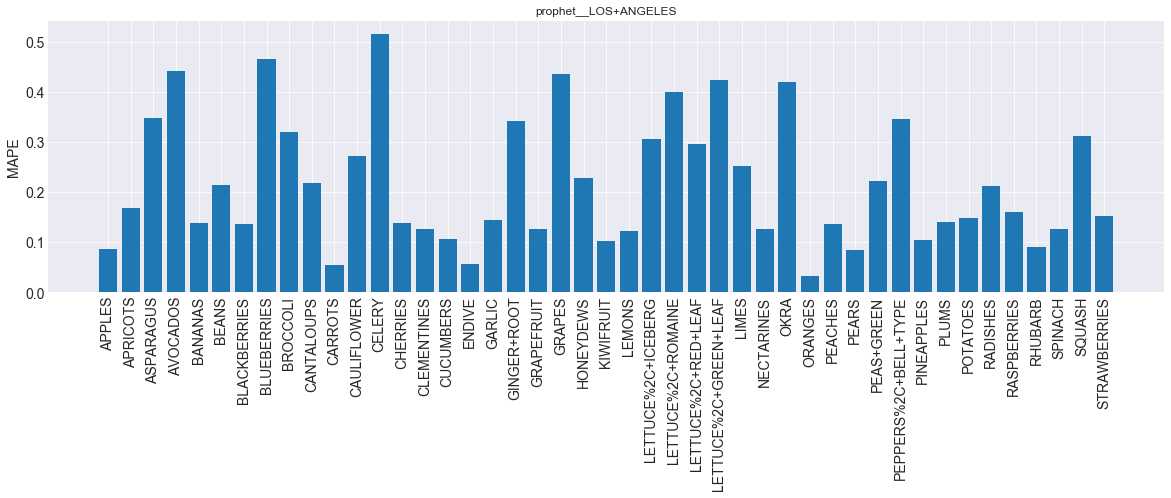

In [25]:
# now visualize the test performance
results = pd.read_csv('prophet_test_performance.csv')
title = 'prophet_'
for i in cities:
    plot_pct_misses_prophet(results[results['city']==i], i, title)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


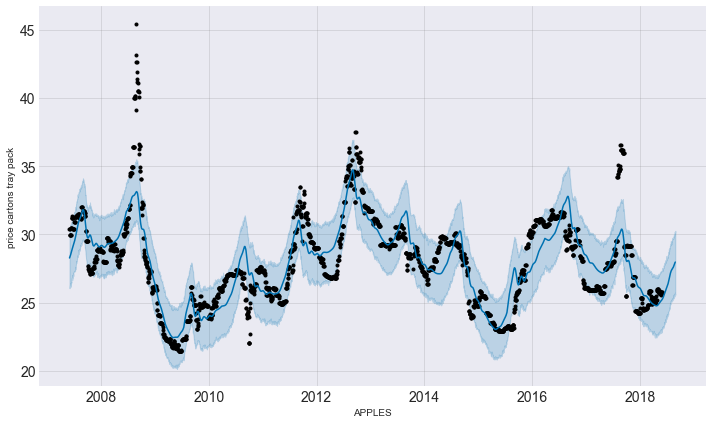

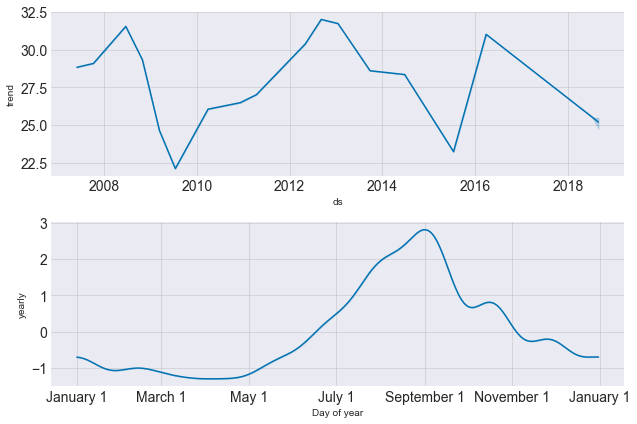

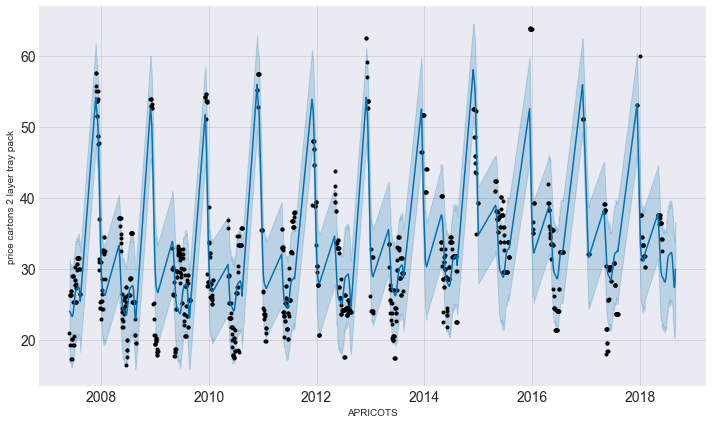

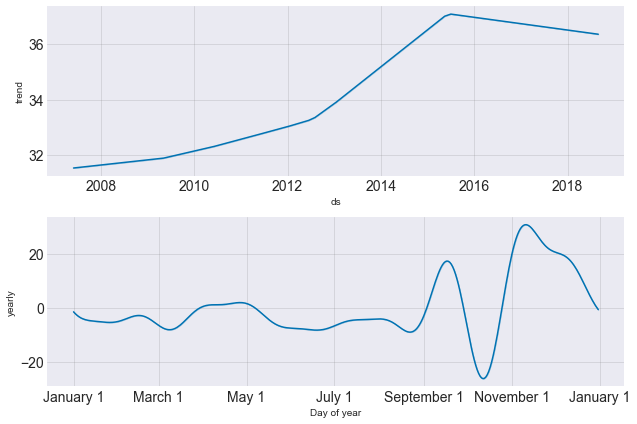

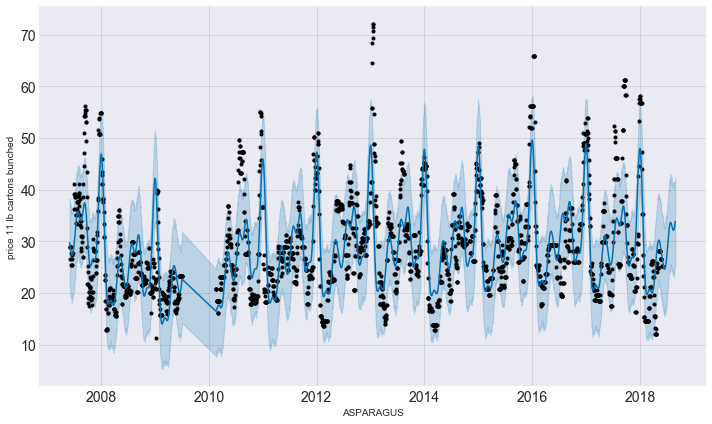

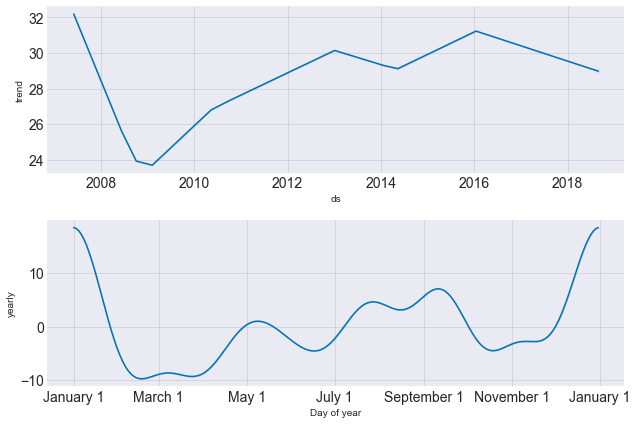

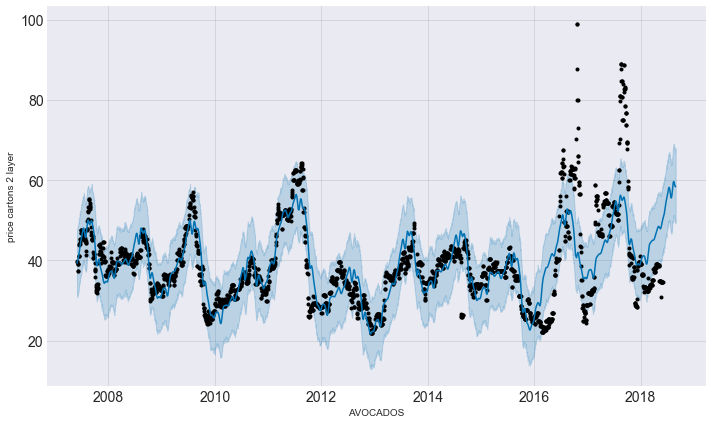

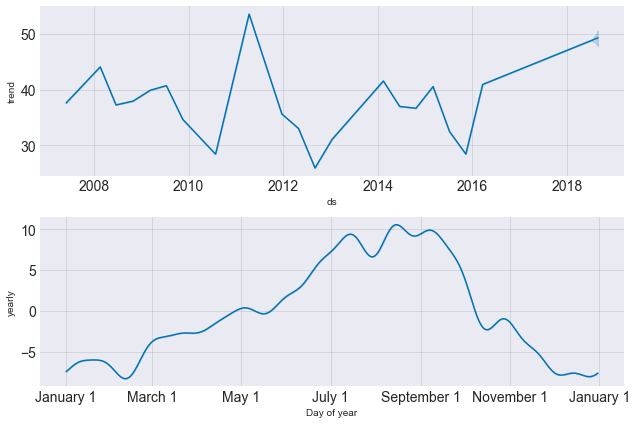

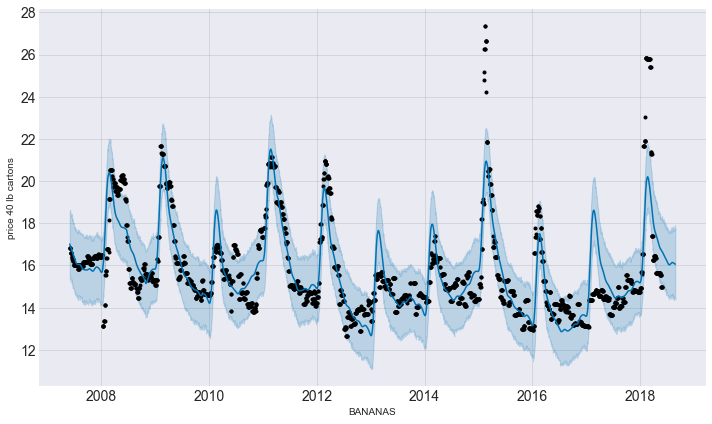

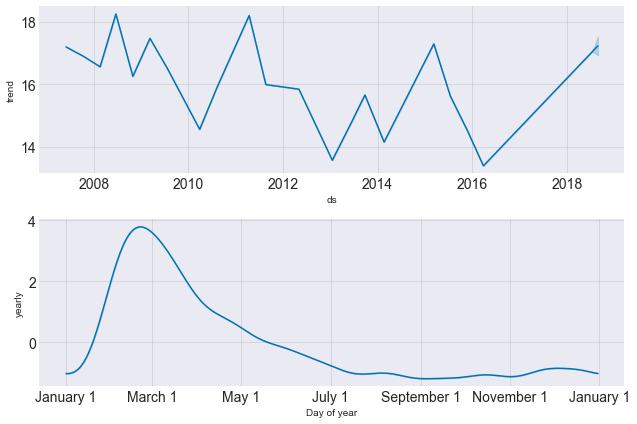

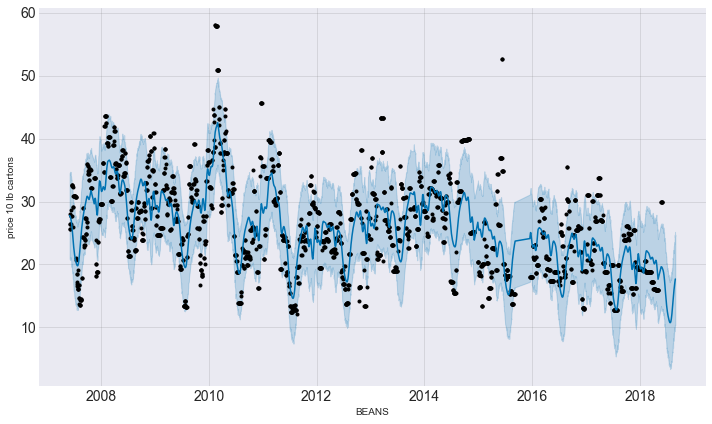

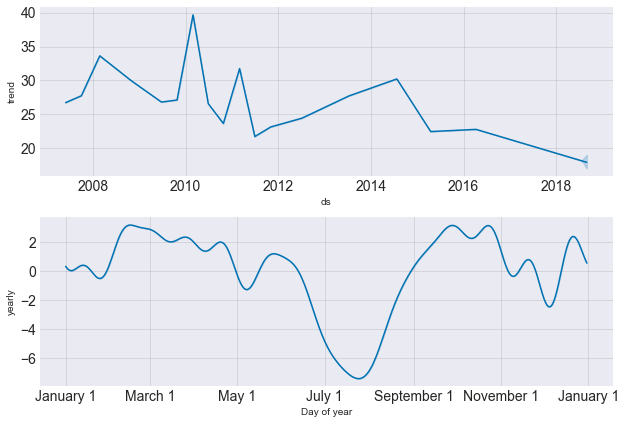

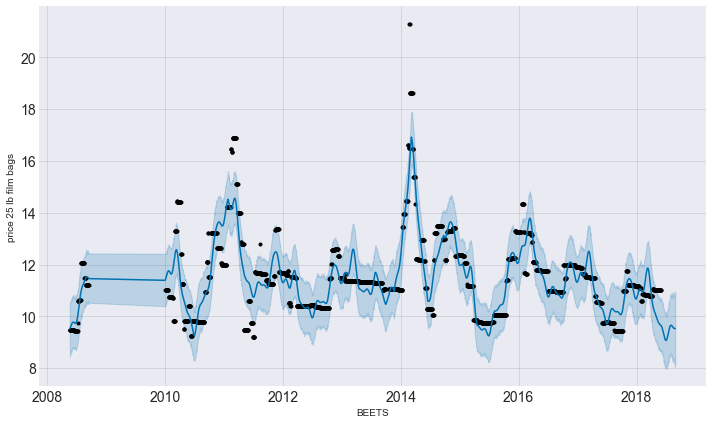

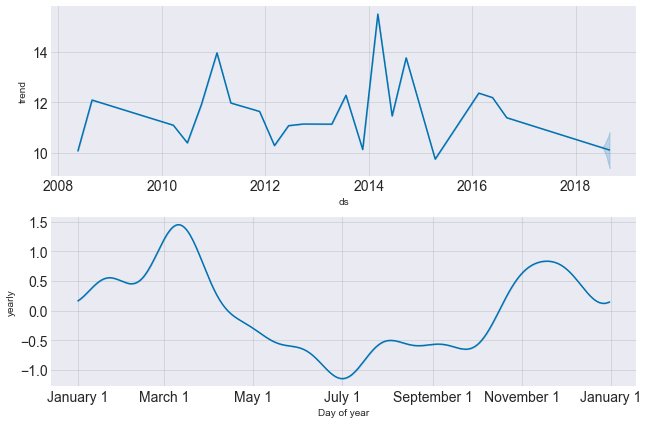

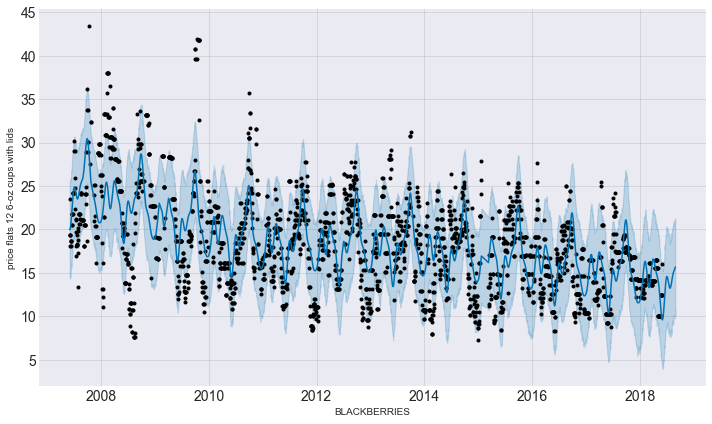

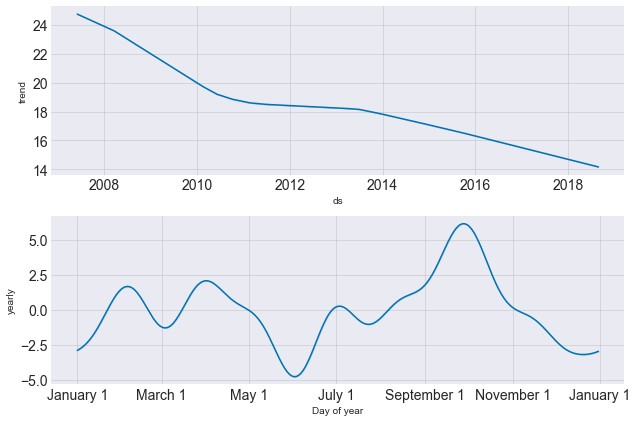

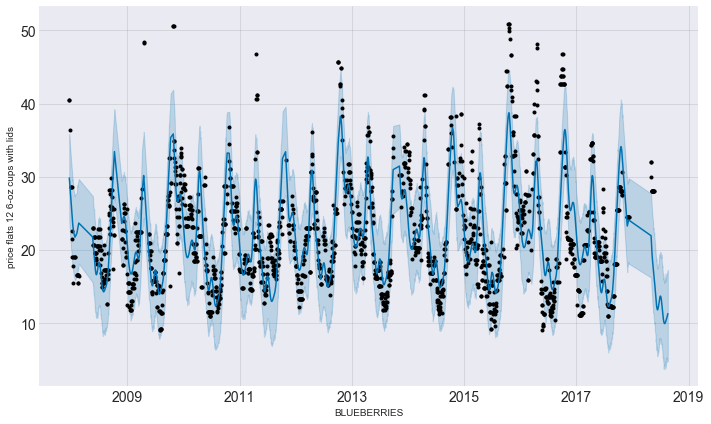

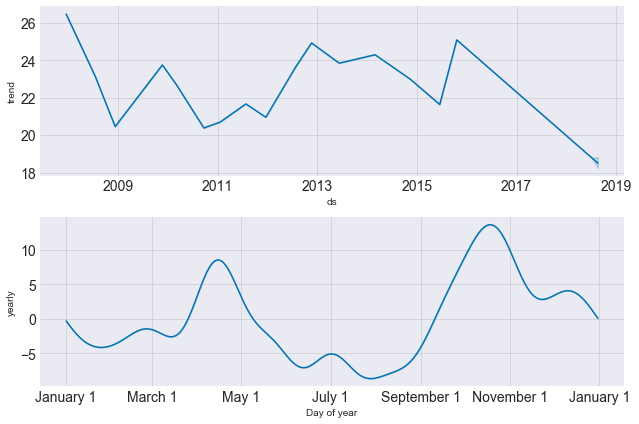

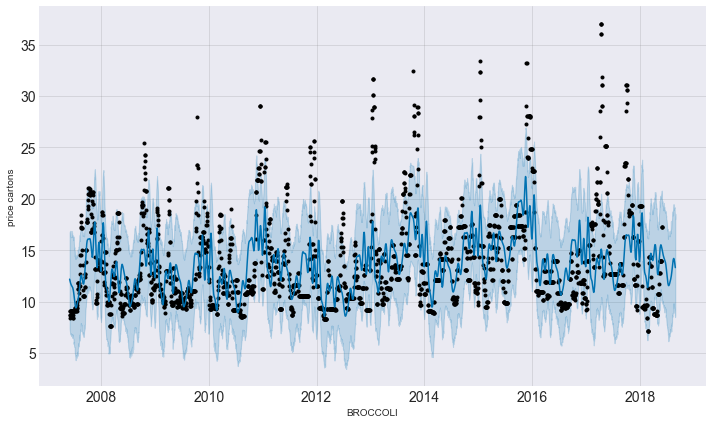

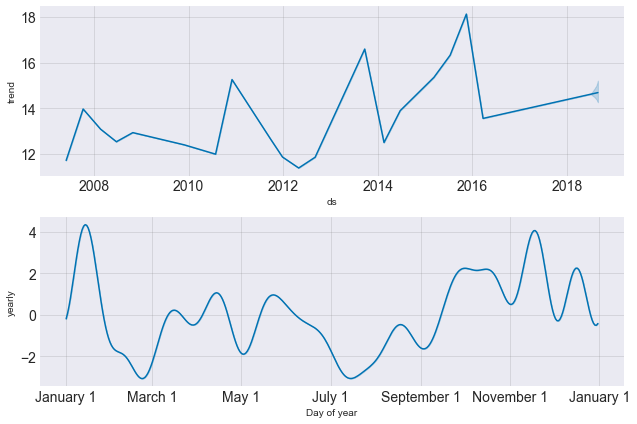

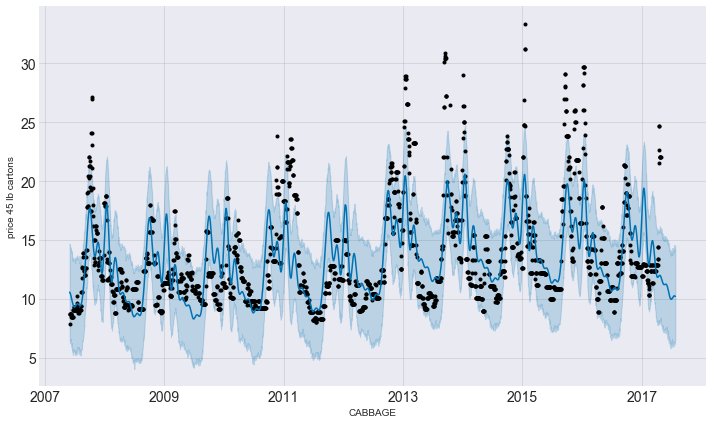

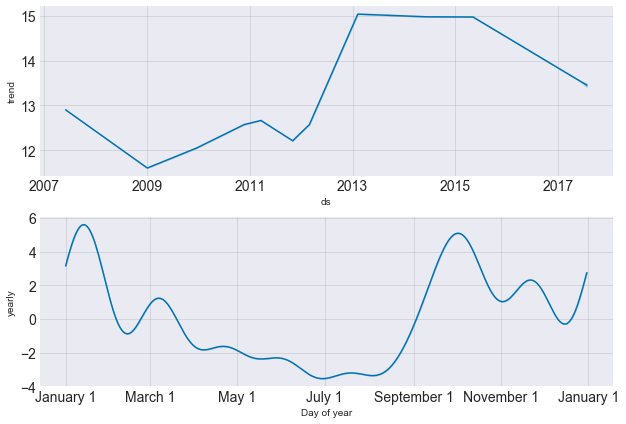

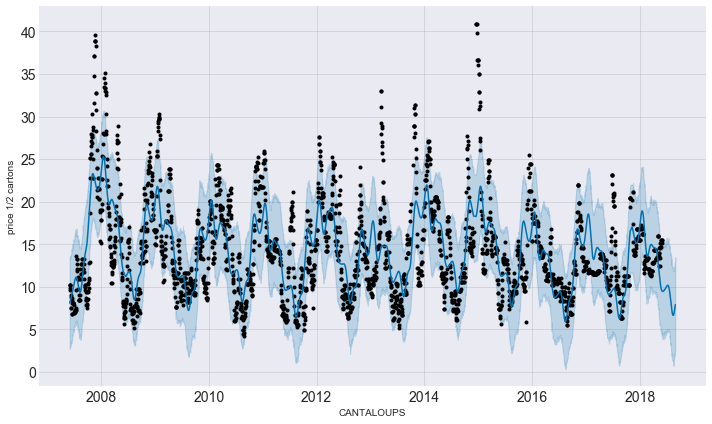

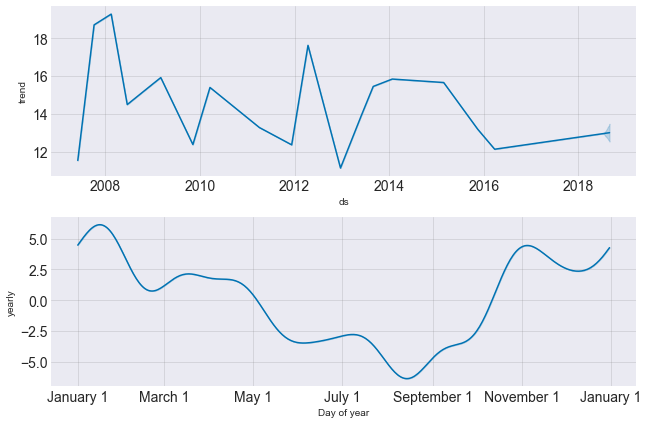

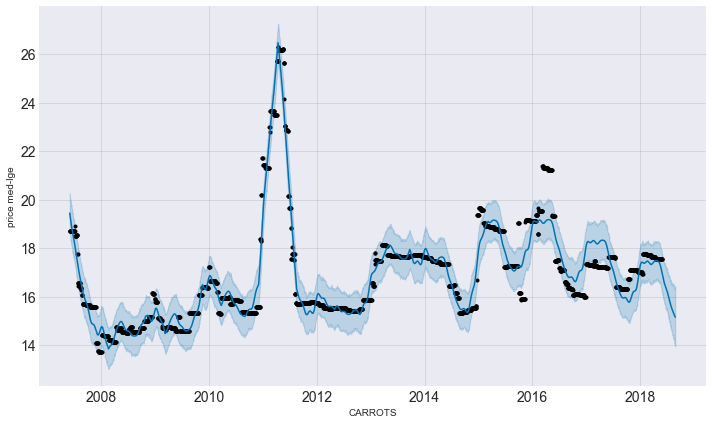

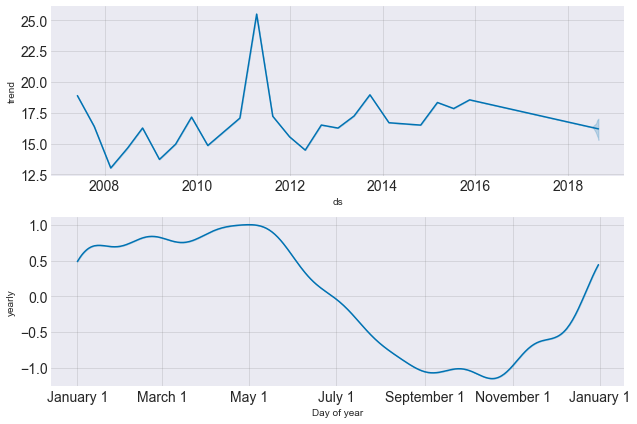

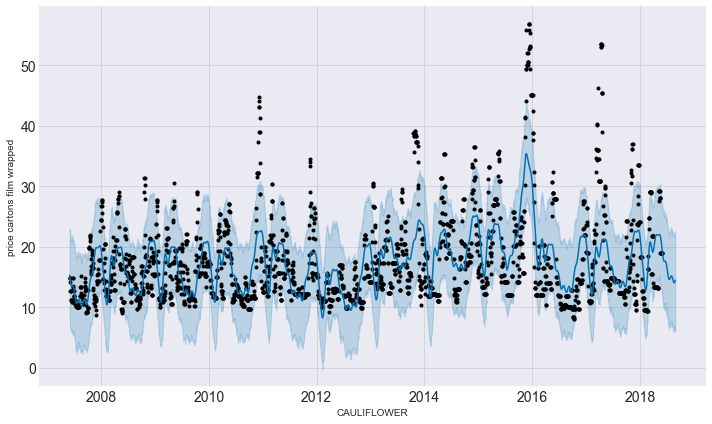

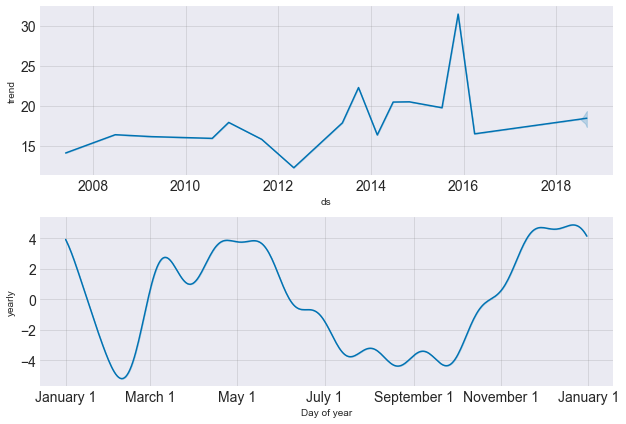

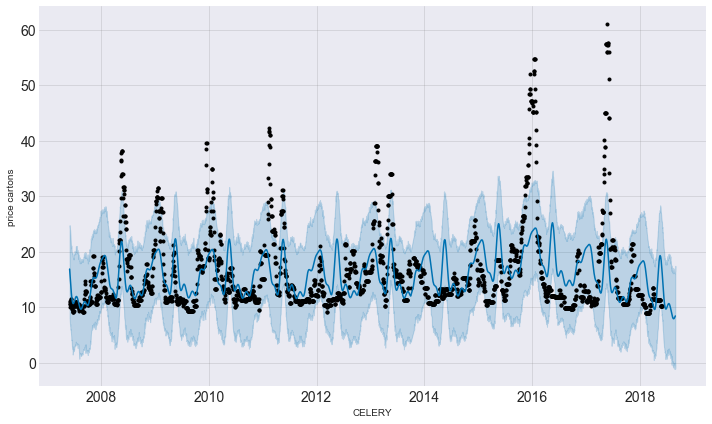

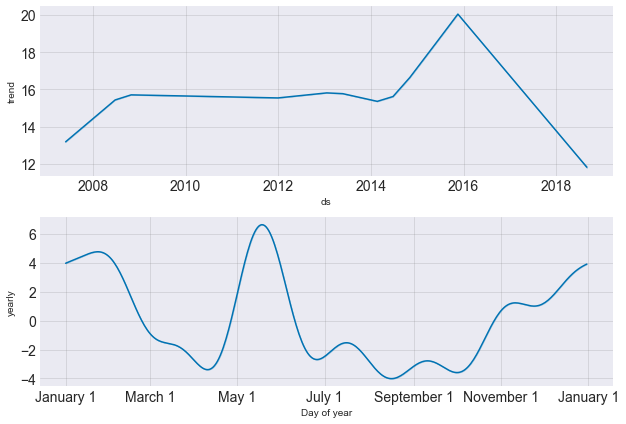

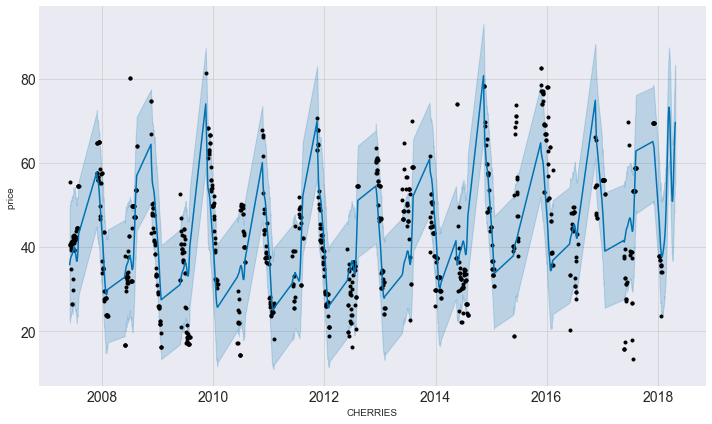

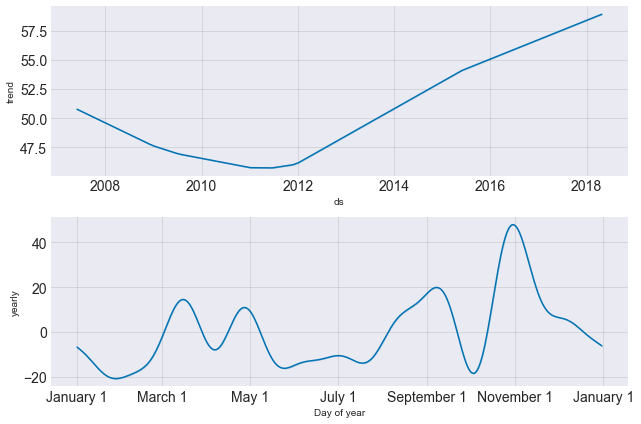

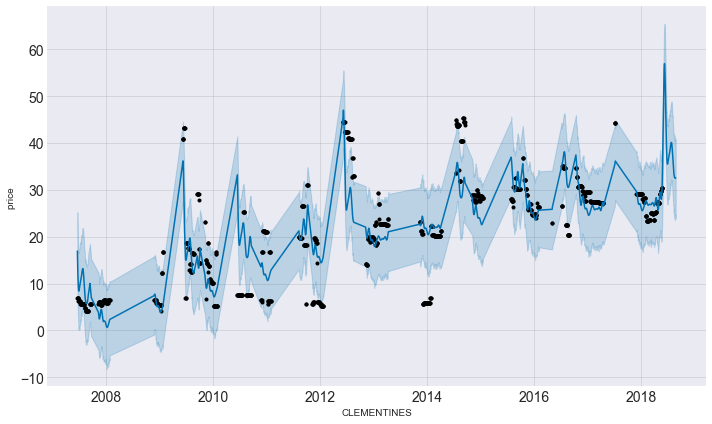

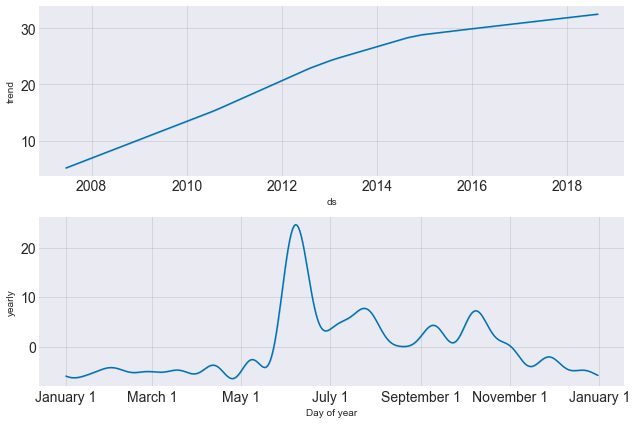

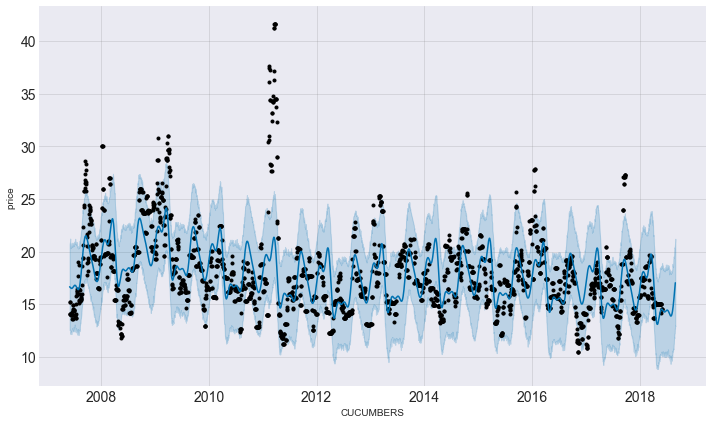

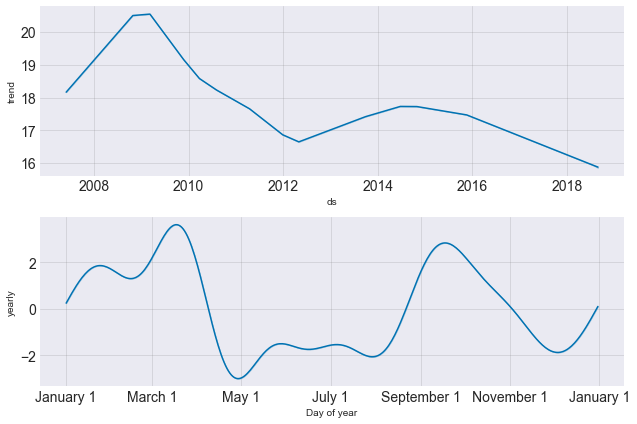

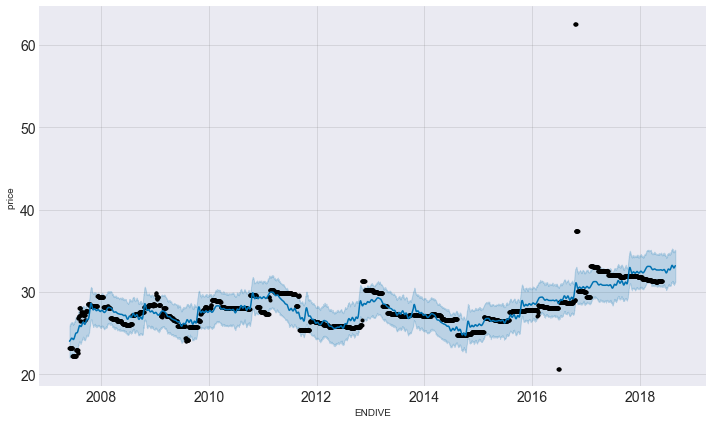

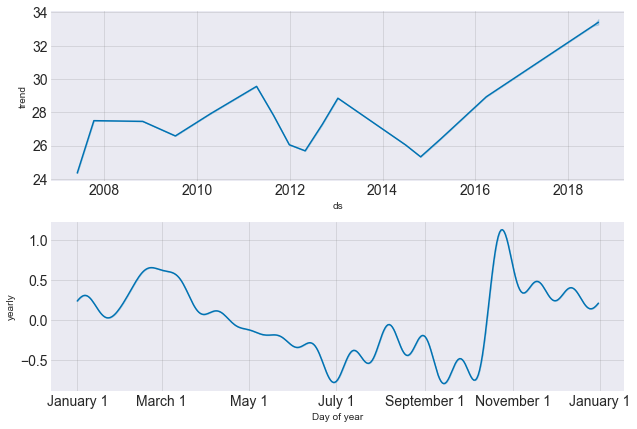

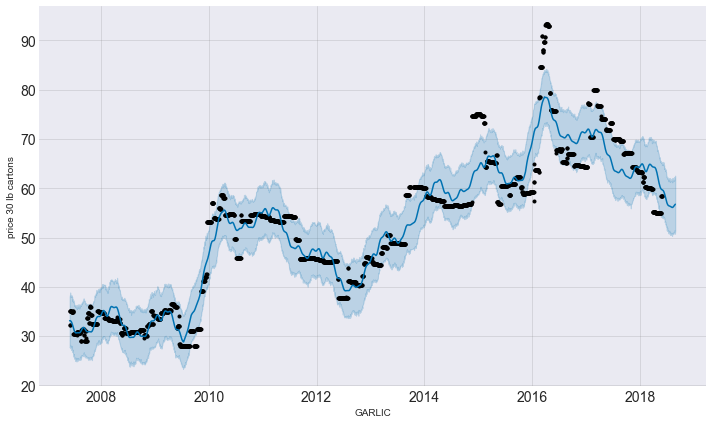

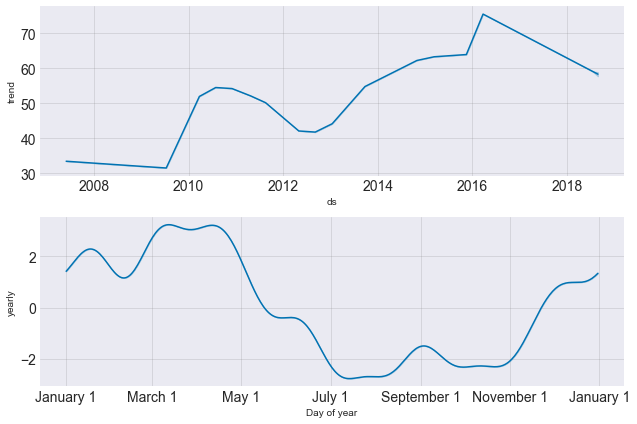

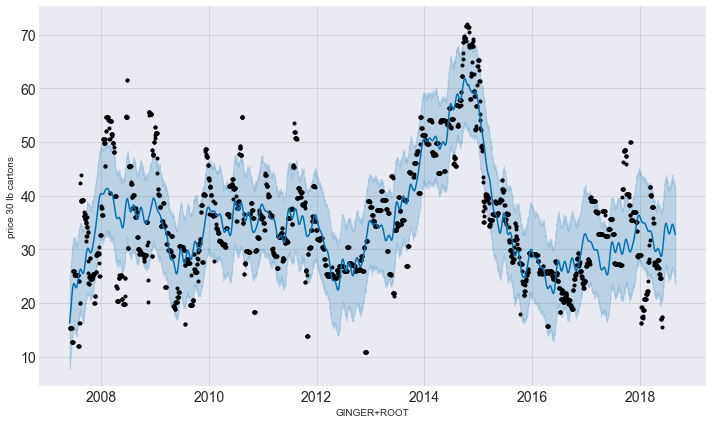

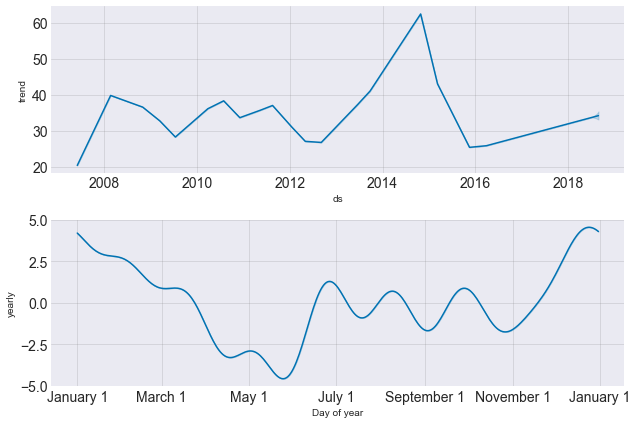

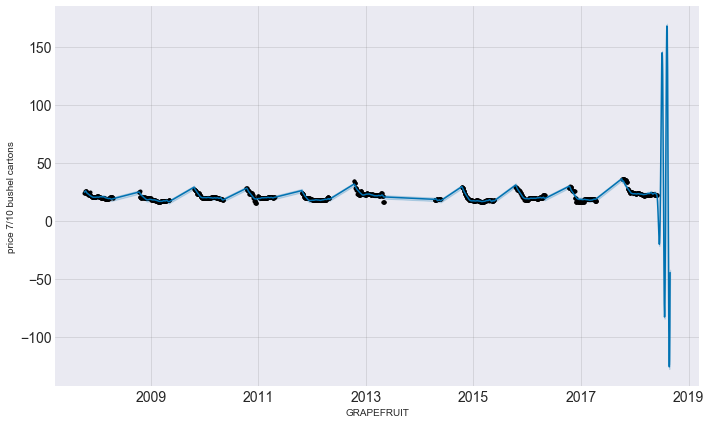

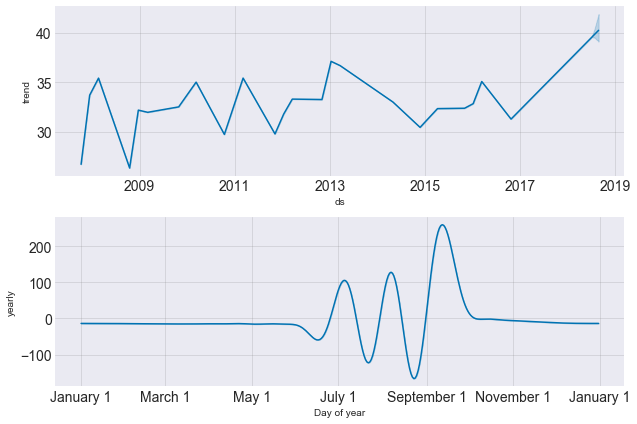

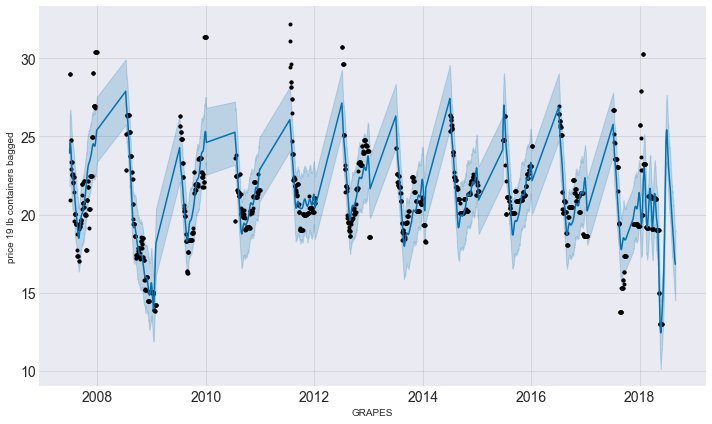

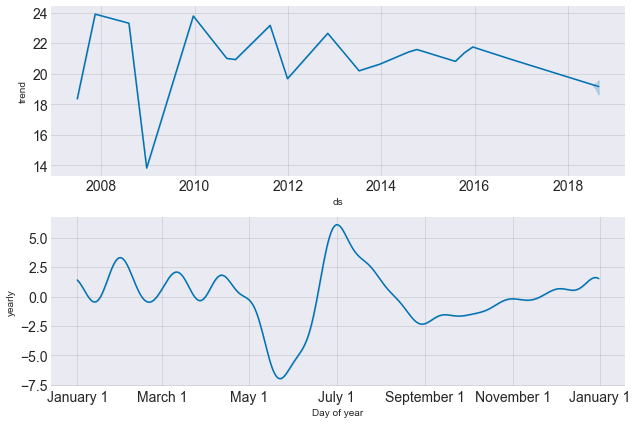

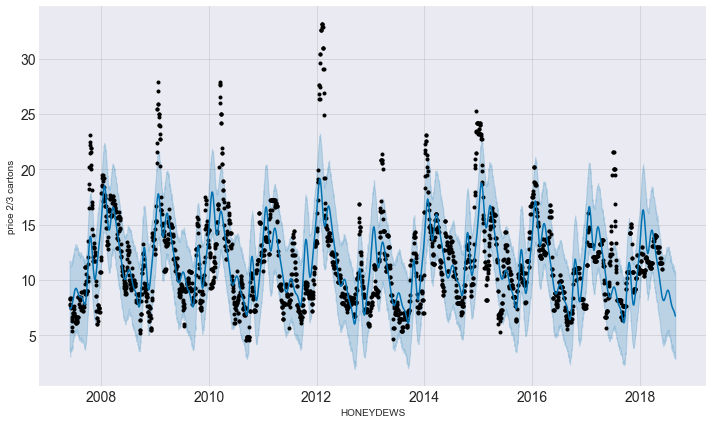

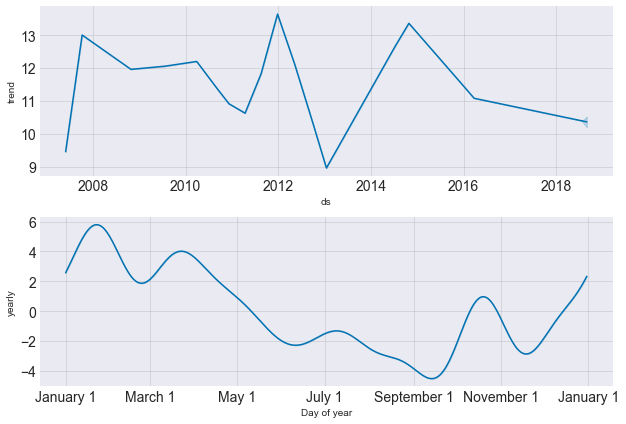

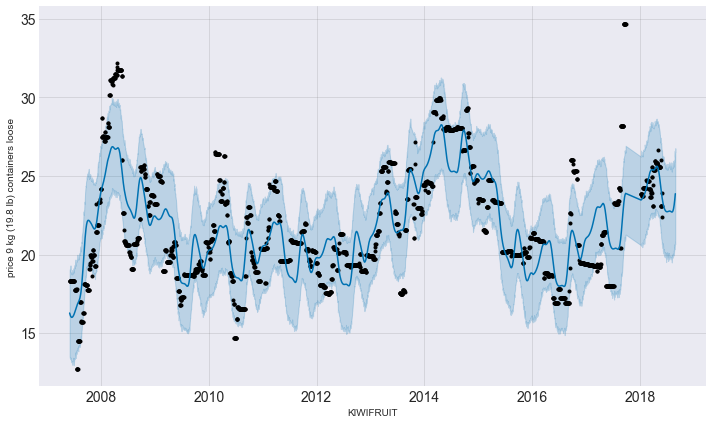

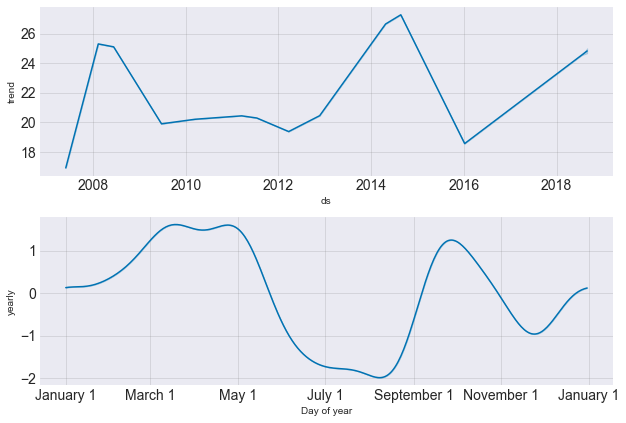

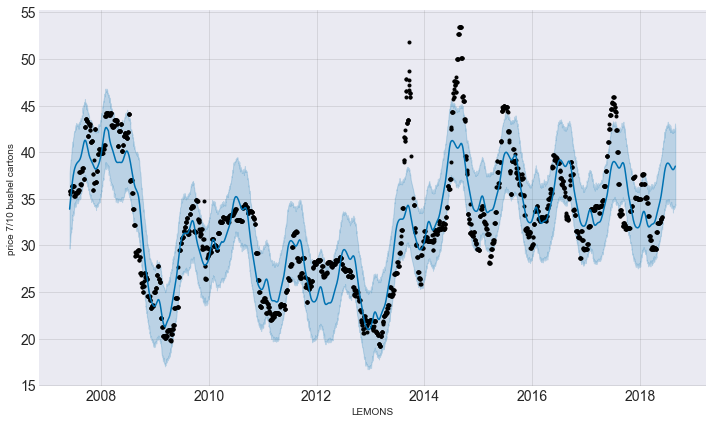

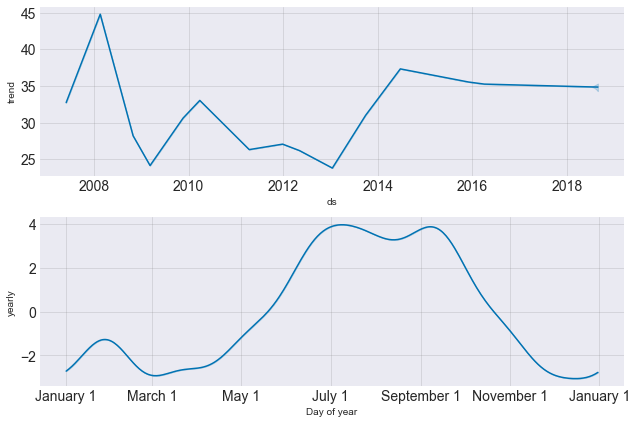

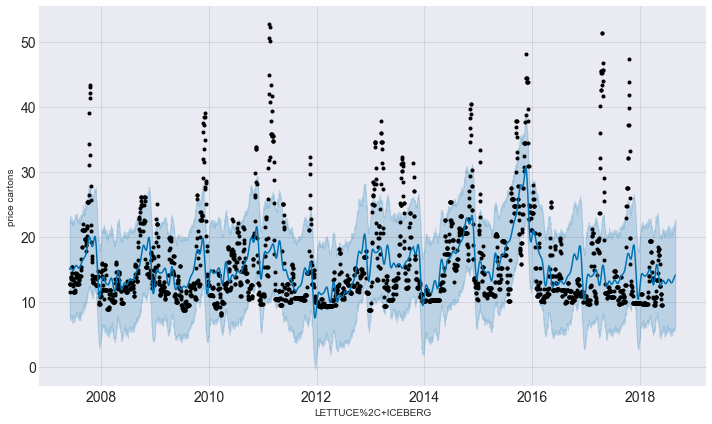

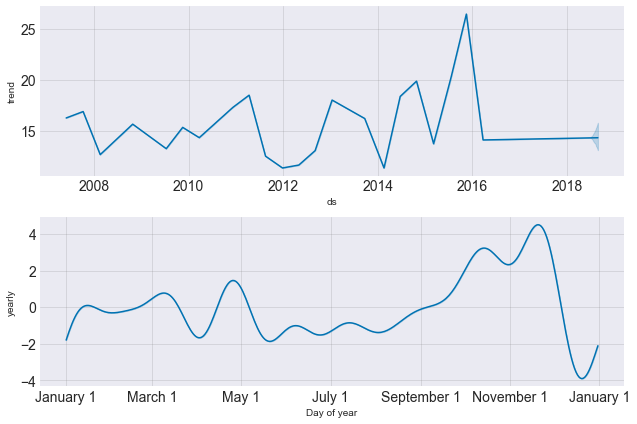

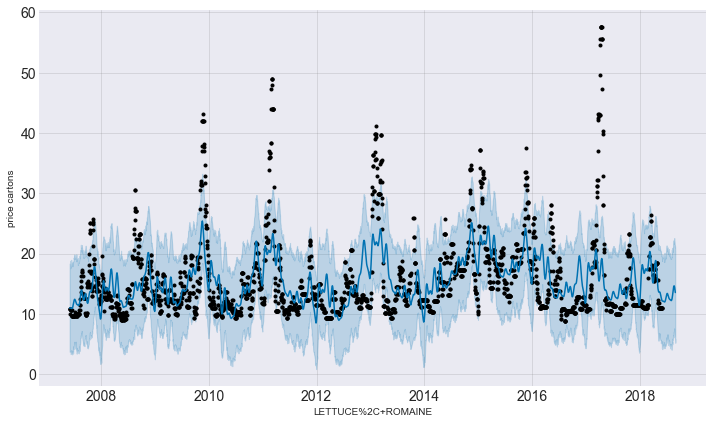

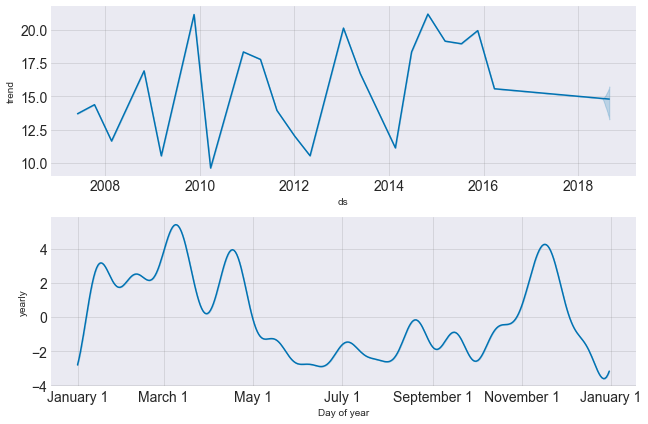

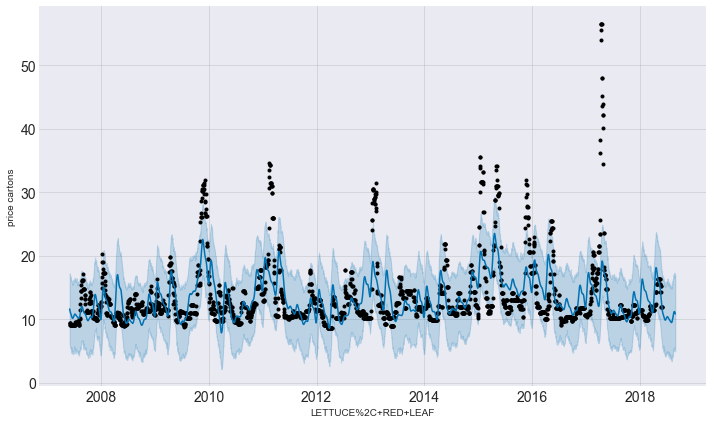

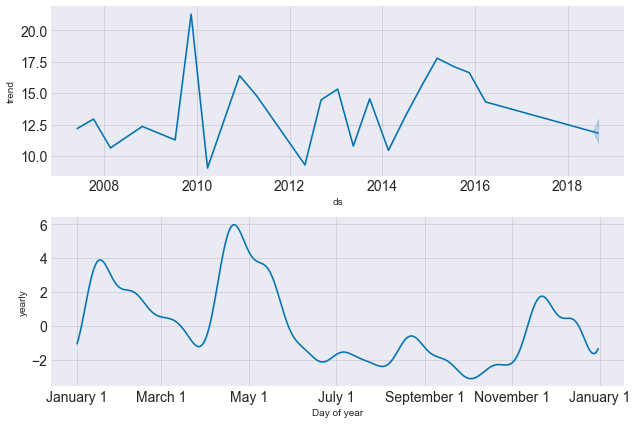

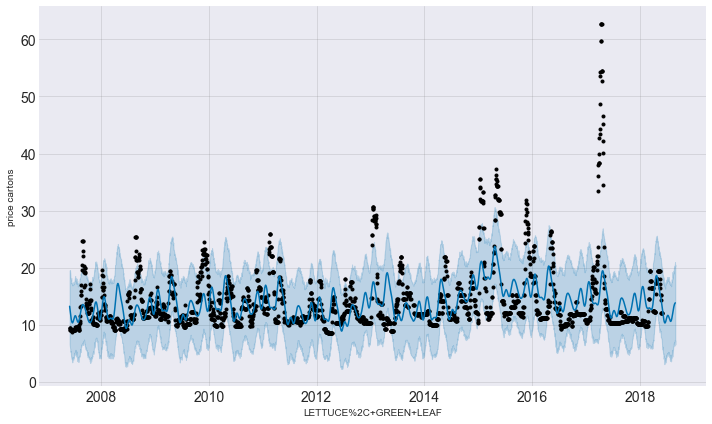

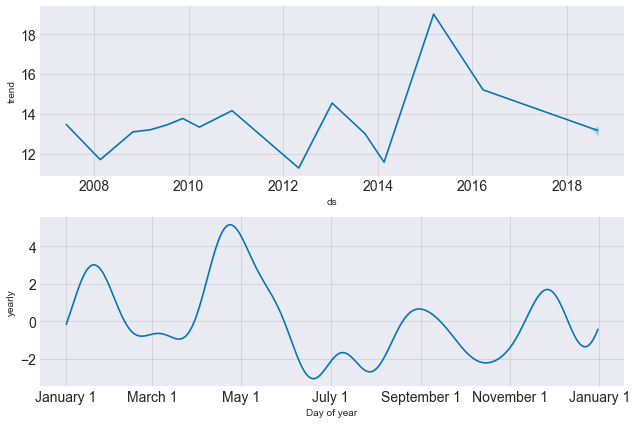

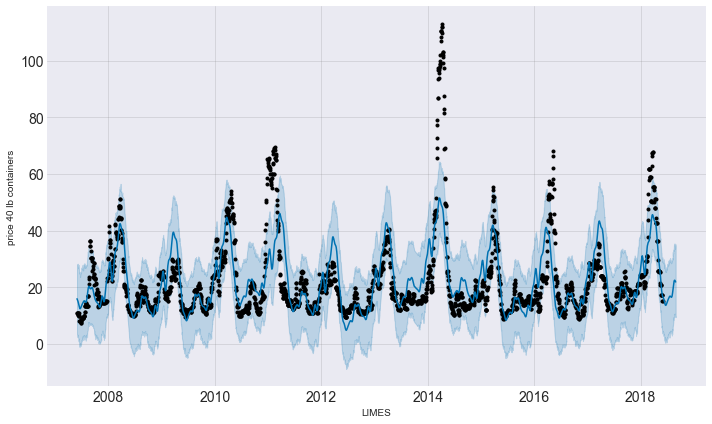

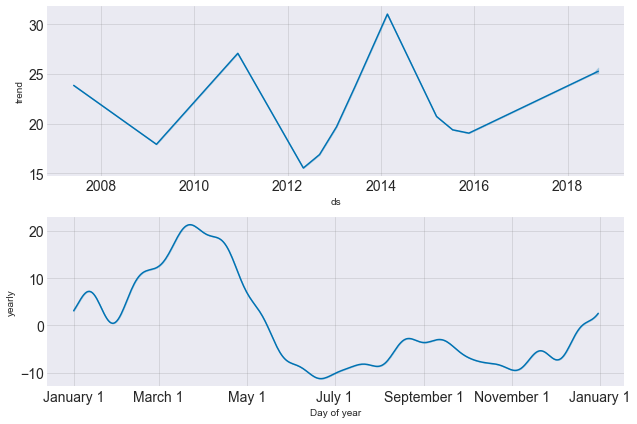

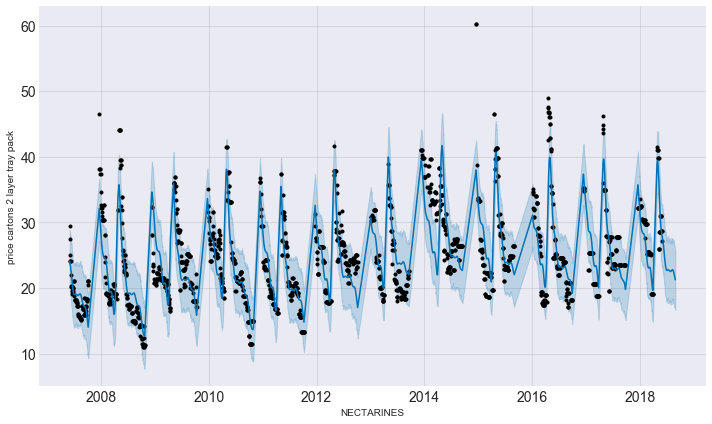

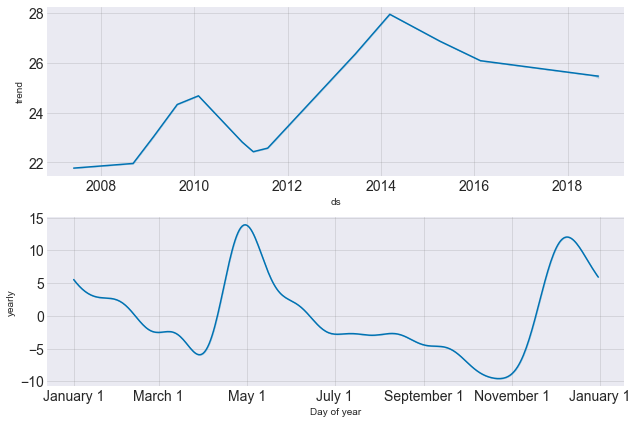

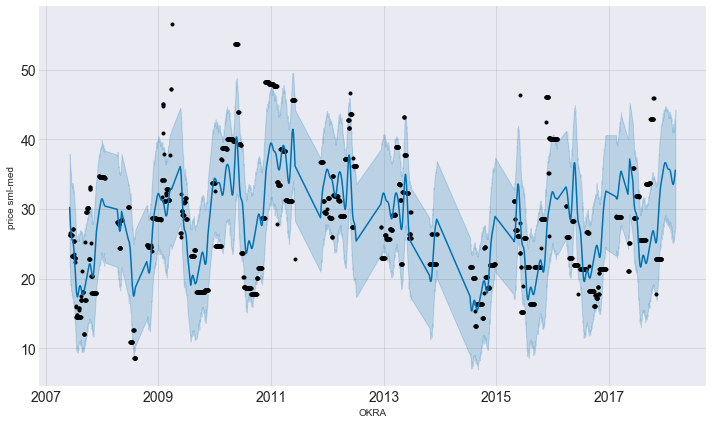

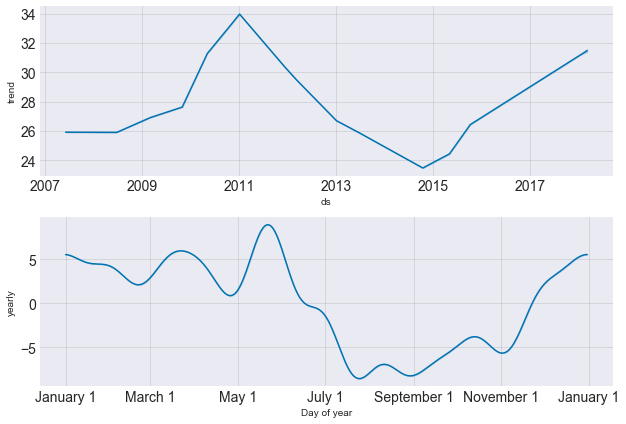

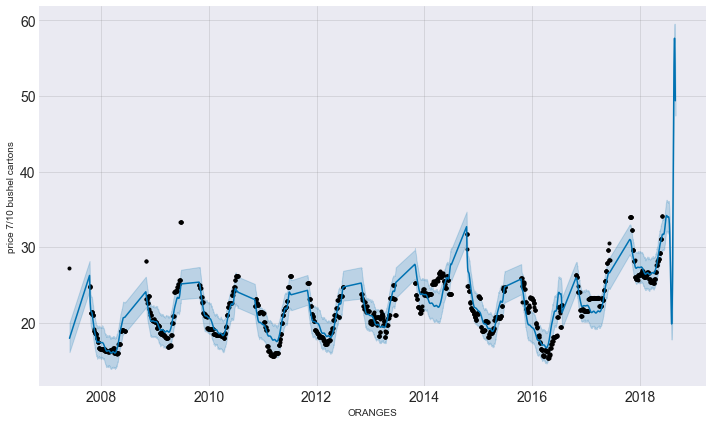

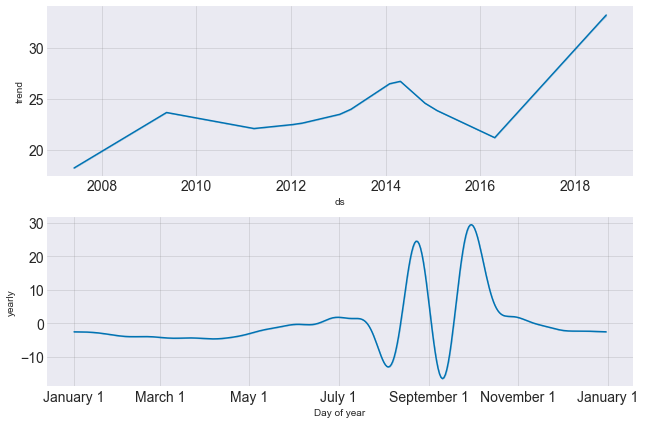

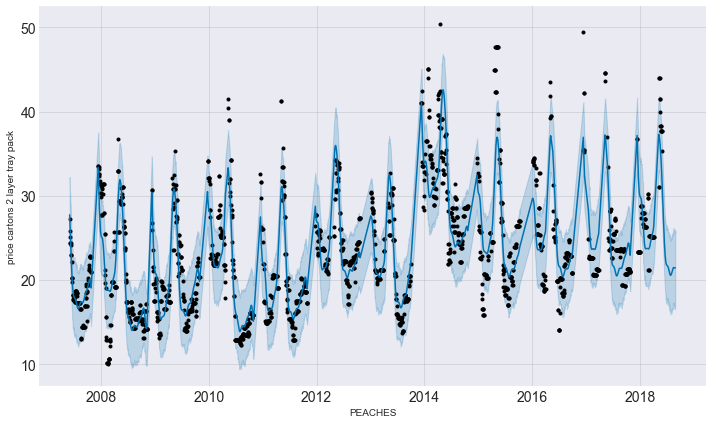

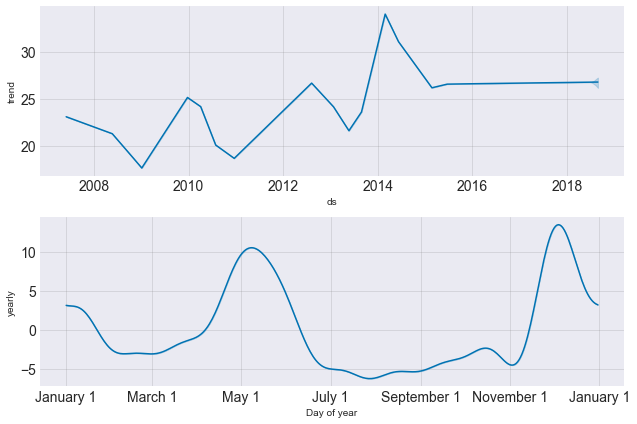

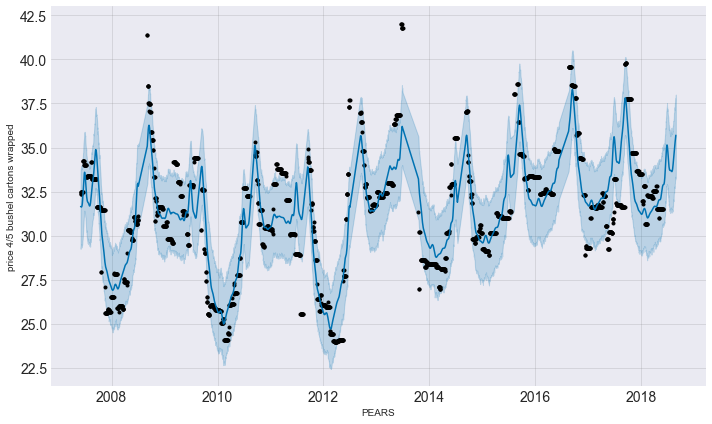

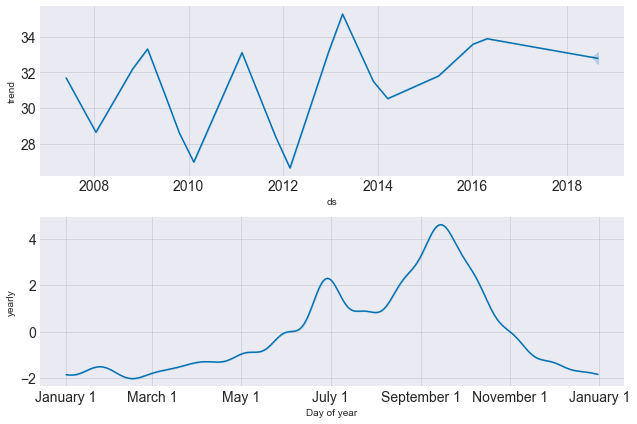

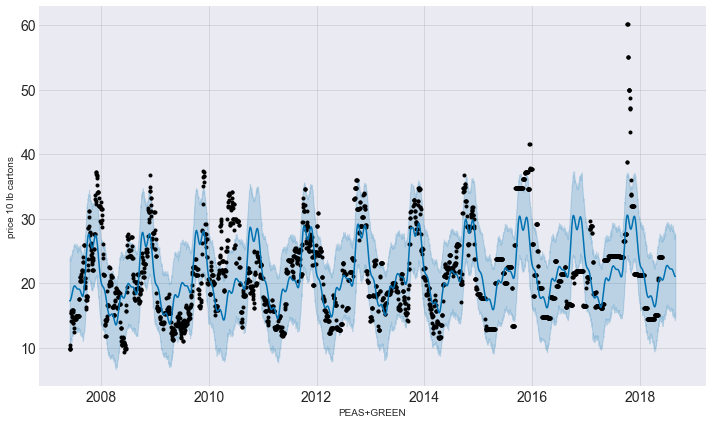

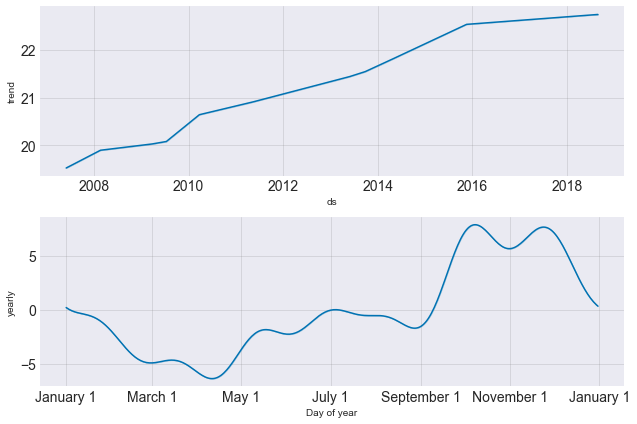

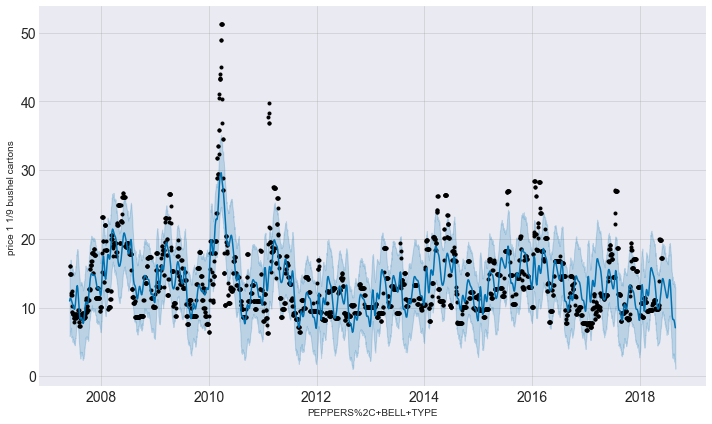

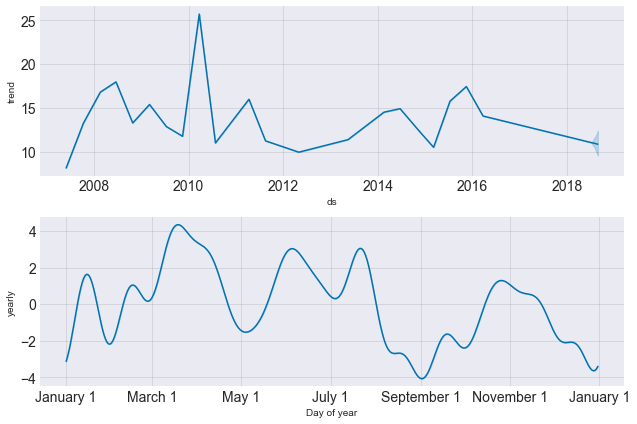

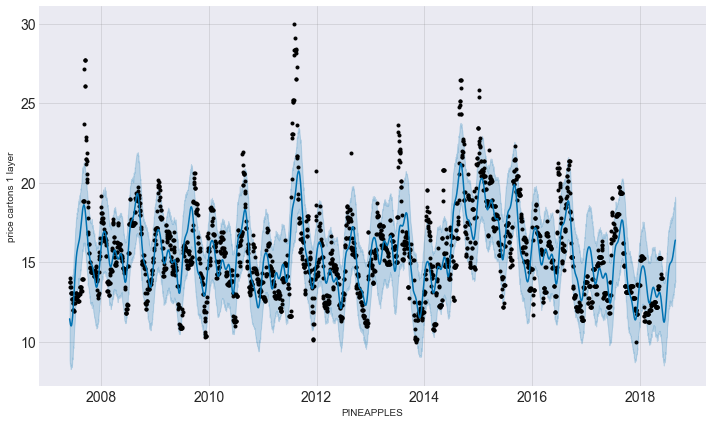

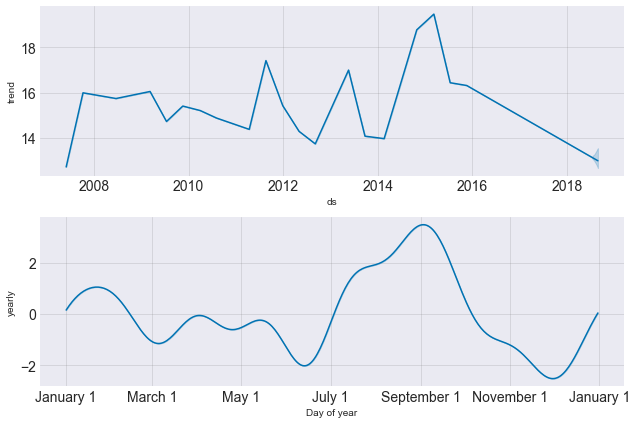

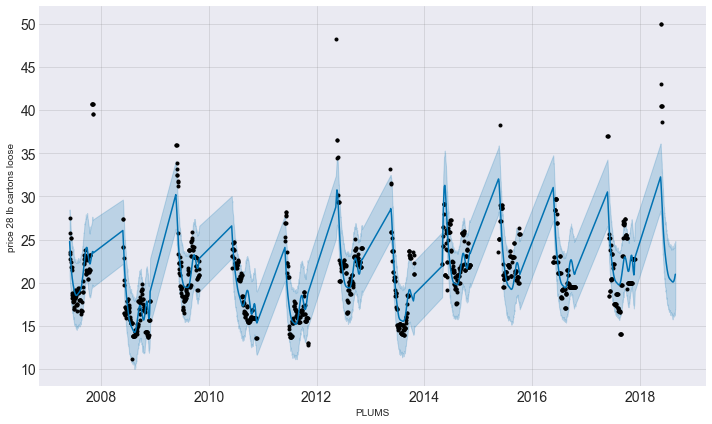

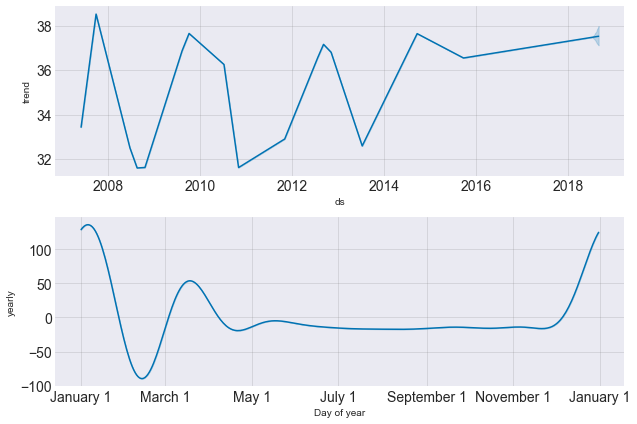

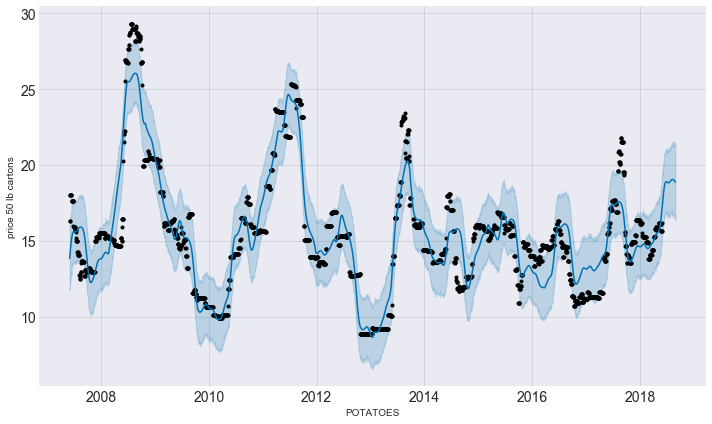

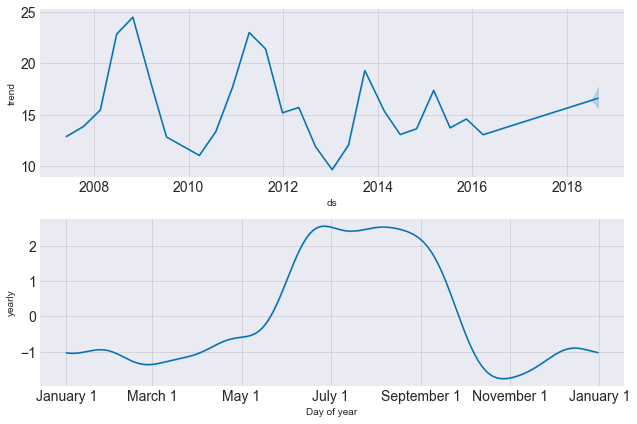

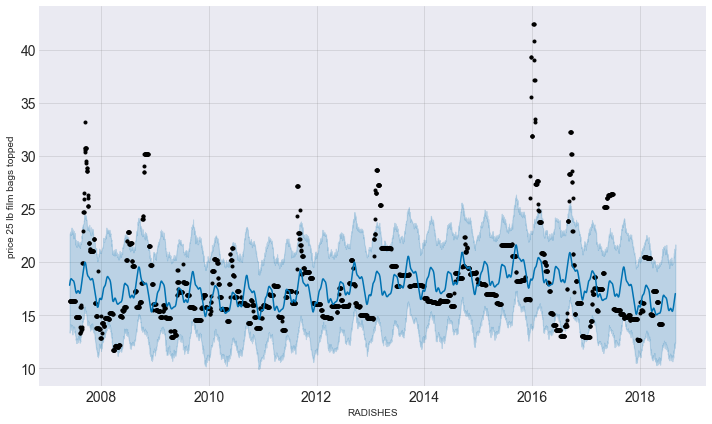

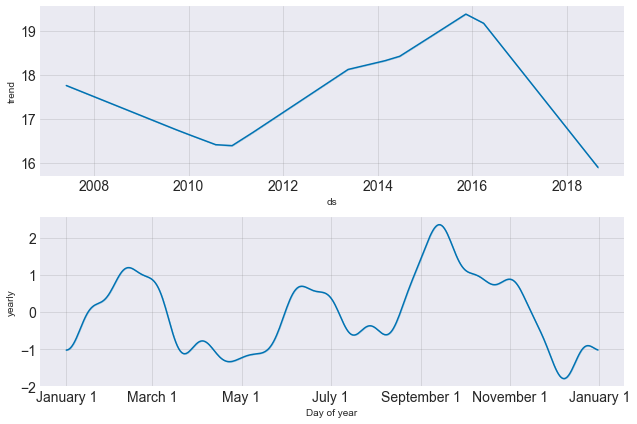

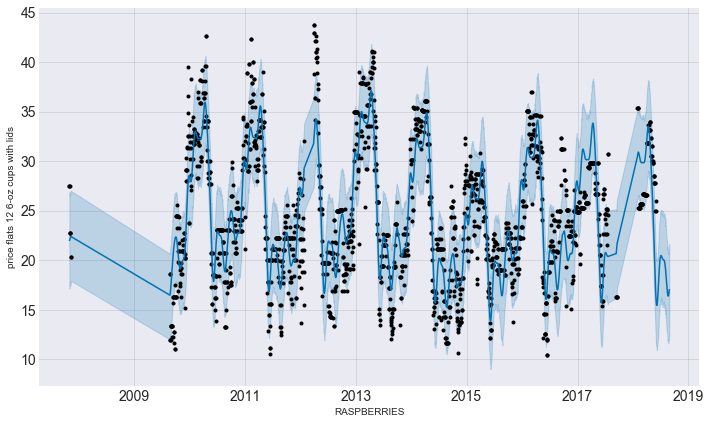

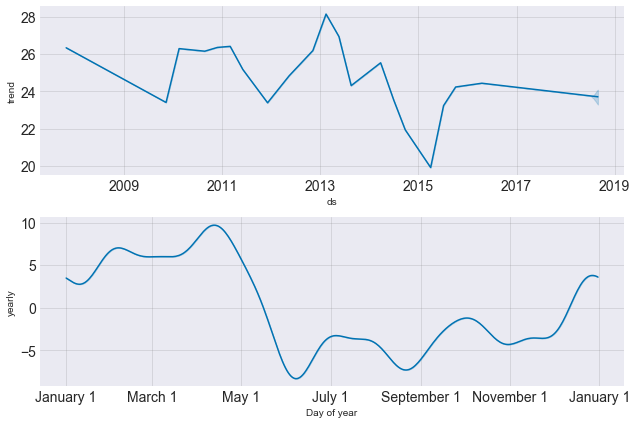

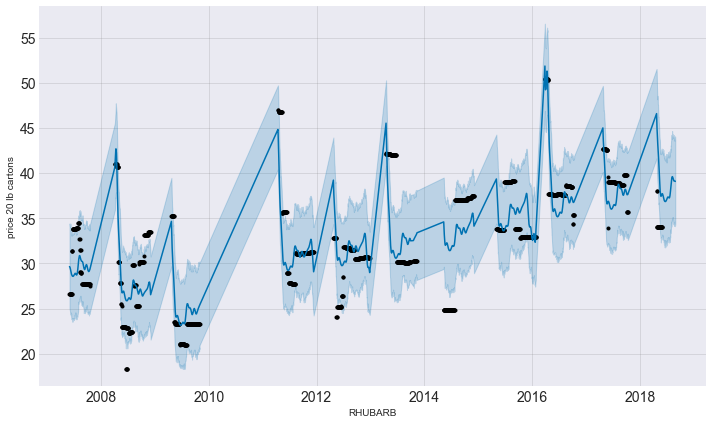

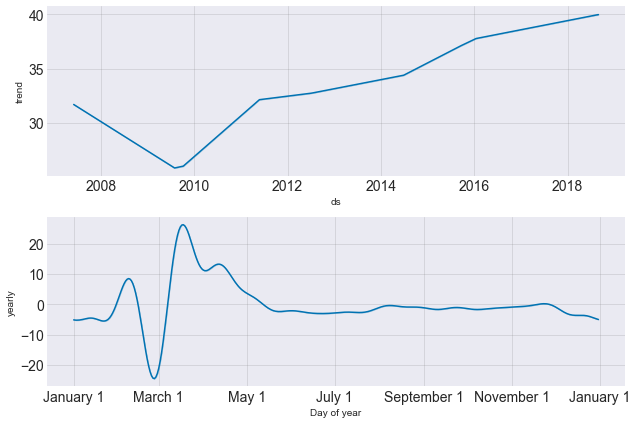

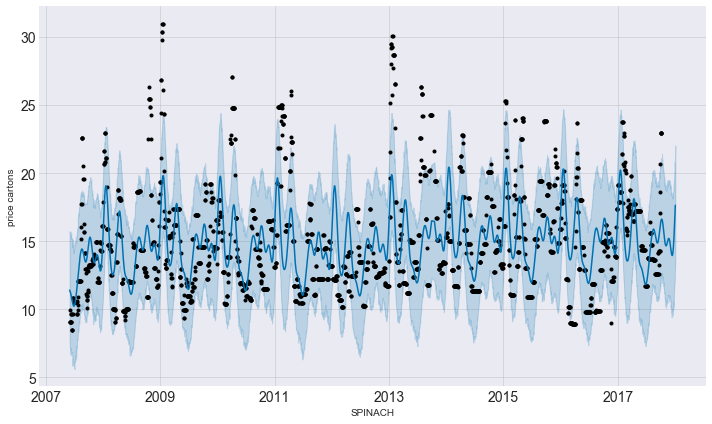

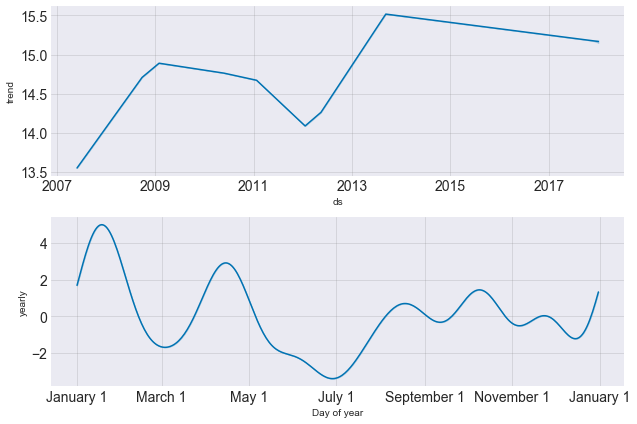

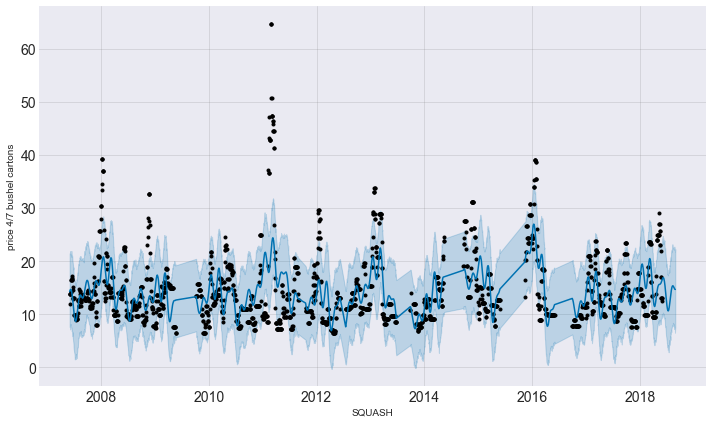

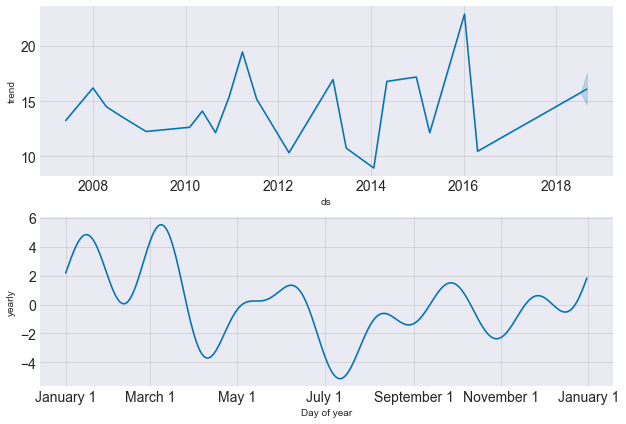

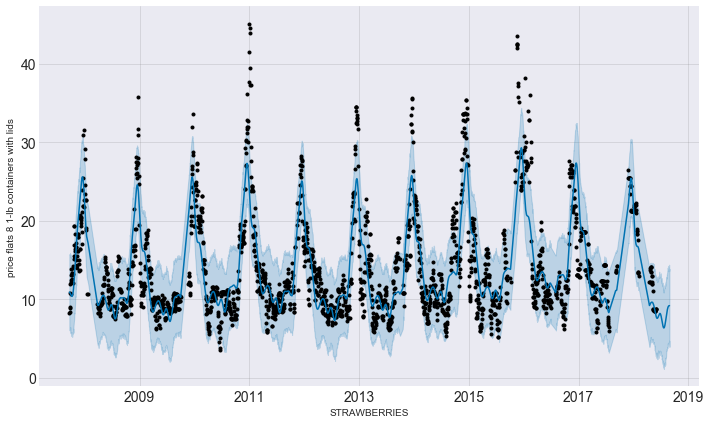

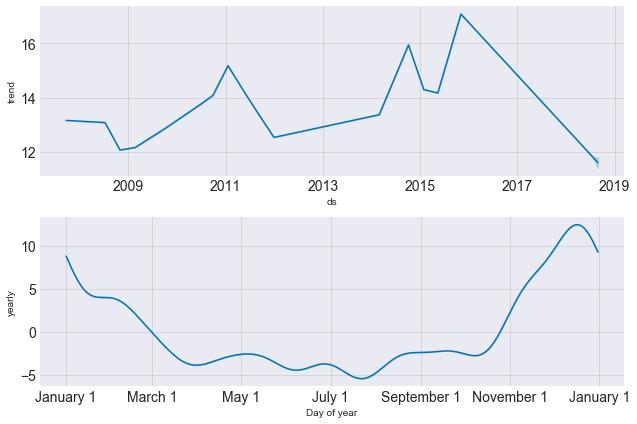

In [23]:
# now run the predictions
predict_horizon = 90
# read in best parameters dataframe
best_params = pd.read_csv('prophet_crossval_bestparams.csv')
test_stats = []
for index, row in best_params.iterrows():
    # read in data
    data = read_trimmed_data_prophet(row['city'], row['veggie'], datadir)
    # double readin for now
    useful_info = read_trimmed_data_notprophet(row['city'], row['veggie'], datadir)
    # initialize prophet model with sampled parameters, fit data
    m = fp.Prophet(weekly_seasonality=False, daily_seasonality=False, 
                  changepoint_range=row['chgpt_range'],
                  changepoint_prior_scale=row['chgpt_pscale'],
                  yearly_seasonality=row['yrly_season'],
                  seasonality_mode=row['season_mode'])
    m.fit(data)
    # grab the item size
    try:
        item_size = useful_info.iloc[0]['Package']
    except KeyError:
        try:
            item_size = useful_info.iloc[0]['Item Size']
        except KeyError:
            item_size = ''
    
    # grab the variety
    try:
        item_type = useful_info.iloc[0]['Variety']
    except KeyError:
        item_type = ''

    # predict the price outlook
    prediction_dates = m.make_future_dataframe(periods=predict_horizon)
    prediction = m.predict(prediction_dates)
    # save the predictions
    prediction_save = prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
    prediction_save = prediction_save.join(data[['ds', 'y']].set_index('ds'))
    prediction_save.to_csv(row['city']+'_'+row['veggie']+'_prophet_output.csv')
    
    # save verbose predictions (for plotting purposes)
    vprediction_save = prediction.set_index('ds')
    vprediction_save = vprediction_save.join(data[['ds', 'y']].set_index('ds'))
    vprediction_save.to_csv(row['city']+'_'+row['veggie']+'_verbose_output.csv')
    
    # compute averages
    actual_predictions = prediction.tail(predict_horizon)
    avg_price = round(actual_predictions['yhat'].mean(),2)
    avg_upper = round(actual_predictions['yhat_upper'].mean(),2)
    avg_lower = round(actual_predictions['yhat_lower'].mean(),2)
    
    # current price
    current_data = data.iloc[-7:]
    current_price = round(current_data['y'].mean(),2)
    
    # historical average
    historical_price = round(data['y'].mean(),2)
    
    # year ago price
    one_year = pd.to_timedelta(pd.np.ceil(365), unit='D')
    most_recent_date = data.iloc[-1]
    most_recent_date = most_recent_date['ds']
    year_ago_date,_ = nearest_date(data['ds'], most_recent_date-one_year)
    year_ago_price = data.iloc[data[data['ds'] == year_ago_date].index[0]-7:data[data['ds'] == year_ago_date].index[0]]
    year_ago_price = round(year_ago_price['y'].mean(),2)
    
    # year ago 3 month outlook actual
    ninety = pd.to_timedelta(pd.np.ceil(90), unit='D')
    year_ago_end3,_ = nearest_date(data['ds'], most_recent_date-one_year+ninety)

    year_ago_outlook = data.iloc[data[data['ds'] == year_ago_date].index[0]:data[data['ds'] == year_ago_end3].index[0]]
    year_ago_outlook = round(year_ago_outlook['y'].mean(),2)
    
    test_stats.append([row['city'], row['veggie'], item_type, item_size, current_price, avg_price, avg_upper, avg_lower, historical_price, year_ago_price, year_ago_outlook])
    
    # plot results
    fig1 = m.plot(prediction, ylabel='price '+item_size, xlabel=row['veggie']).savefig(row['city']+'_'+row['veggie']+'.pdf')
    fig2 = m.plot_components(prediction).savefig(row['city']+'_'+row['veggie']+'_comp'+'.pdf')

output_file = pd.DataFrame(test_stats, columns=['City', 'Item','Variety','Package Size', 'Current Price', '3 Month Prediction', 'uError', 'lError', 'Historical Price', 'Year Ago Price', 'Year Ago Outlook'])

nystuff = output_file[output_file['City']=='NEW+YORK']
nystuff.to_csv('ny_prophet_predictions.csv')

lastuff = output_file[output_file['City']=='LOS+ANGELES']
lastuff.to_csv('la_prophet_predictions.csv')